In [1]:
import pandas as pd

In [2]:
train_full = pd.read_csv('train.csv', index_col='id')

In [3]:
train_full.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_full[['keyword', 'location']].value_counts().head()

keyword      location
sandstorm    USA         17
loud%20bang  Kenya       16
flood        New York    13
body%20bag   New York    10
arsonist     ss          10
dtype: int64

In [5]:
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns

<AxesSubplot:xlabel='target', ylabel='count'>

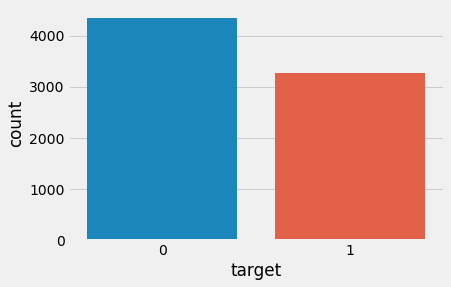

In [6]:
sns.countplot(x='target', data=train_full)

In [7]:
train_full[['keyword', 'location']] = train_full[['keyword', 'location']].fillna(value='none')
train_full.head()

,keyword,location,text,target
id,,,,
1,none,none,Our Deeds are the Reason of this #earthquake M...,1
4,none,none,Forest fire near La Ronge Sask. Canada,1
5,none,none,All residents asked to 'shelter in place' are ...,1
6,none,none,"13,000 people receive #wildfires evacuation or...",1
7,none,none,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train_full['hashtag'] = train_full['text'].apply(lambda x: 1 if '#' in x else 0)
train_full.head()

,keyword,location,text,target,hashtag
id,,,,,
1,none,none,Our Deeds are the Reason of this #earthquake M...,1,1
4,none,none,Forest fire near La Ronge Sask. Canada,1,0
5,none,none,All residents asked to 'shelter in place' are ...,1,0
6,none,none,"13,000 people receive #wildfires evacuation or...",1,1
7,none,none,Just got sent this photo from Ruby #Alaska as ...,1,1


<AxesSubplot:xlabel='target', ylabel='count'>

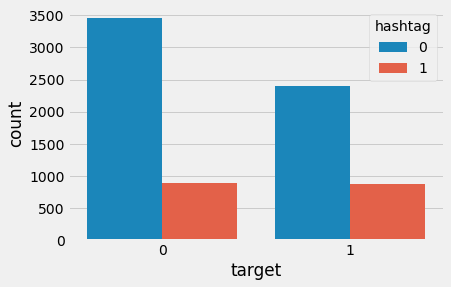

In [9]:
sns.countplot(x='target', data=train_full, hue='hashtag')

In [10]:
test_text = train_full['text'].iloc[7]

In [11]:
test_text

"I'm on top of the hill and I can see a fire in the woods..."

In [12]:
from transformers import pipeline

In [13]:
nlp = pipeline('sentiment-analysis')

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-finetuned-sst-2-english-modelcard.json' to download model card file.
Creating an empty model card.


In [14]:
result = nlp(test_text, return_all_scores=True)

In [15]:
result

[{'label': 'POSITIVE', 'score': 0.998032}]

In [16]:
train_full['sentiment_label'] = train_full['text'].apply(lambda text: nlp(text)[0]['label'])
train_full['sentiment_conf'] = train_full['text'].apply(lambda text: nlp(text)[0]['score'])
train_full.head()

,keyword,location,text,target,hashtag,sentiment_label,sentiment_conf
id,,,,,,,
1,none,none,Our Deeds are the Reason of this #earthquake M...,1,1,NEGATIVE,0.726392
4,none,none,Forest fire near La Ronge Sask. Canada,1,0,NEGATIVE,0.984948
5,none,none,All residents asked to 'shelter in place' are ...,1,0,NEGATIVE,0.979095
6,none,none,"13,000 people receive #wildfires evacuation or...",1,1,NEGATIVE,0.984415
7,none,none,Just got sent this photo from Ruby #Alaska as ...,1,1,NEGATIVE,0.973235


In [17]:
train_full['sentiment_label'] = train_full['sentiment_label'].apply(lambda text: 1 if 'POSITIVE' in text else 0)
train_full.head()

,keyword,location,text,target,hashtag,sentiment_label,sentiment_conf
id,,,,,,,
1,none,none,Our Deeds are the Reason of this #earthquake M...,1,1,0,0.726392
4,none,none,Forest fire near La Ronge Sask. Canada,1,0,0,0.984948
5,none,none,All residents asked to 'shelter in place' are ...,1,0,0,0.979095
6,none,none,"13,000 people receive #wildfires evacuation or...",1,1,0,0.984415
7,none,none,Just got sent this photo from Ruby #Alaska as ...,1,1,0,0.973235


C:\Users\jpzam\Anaconda3\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


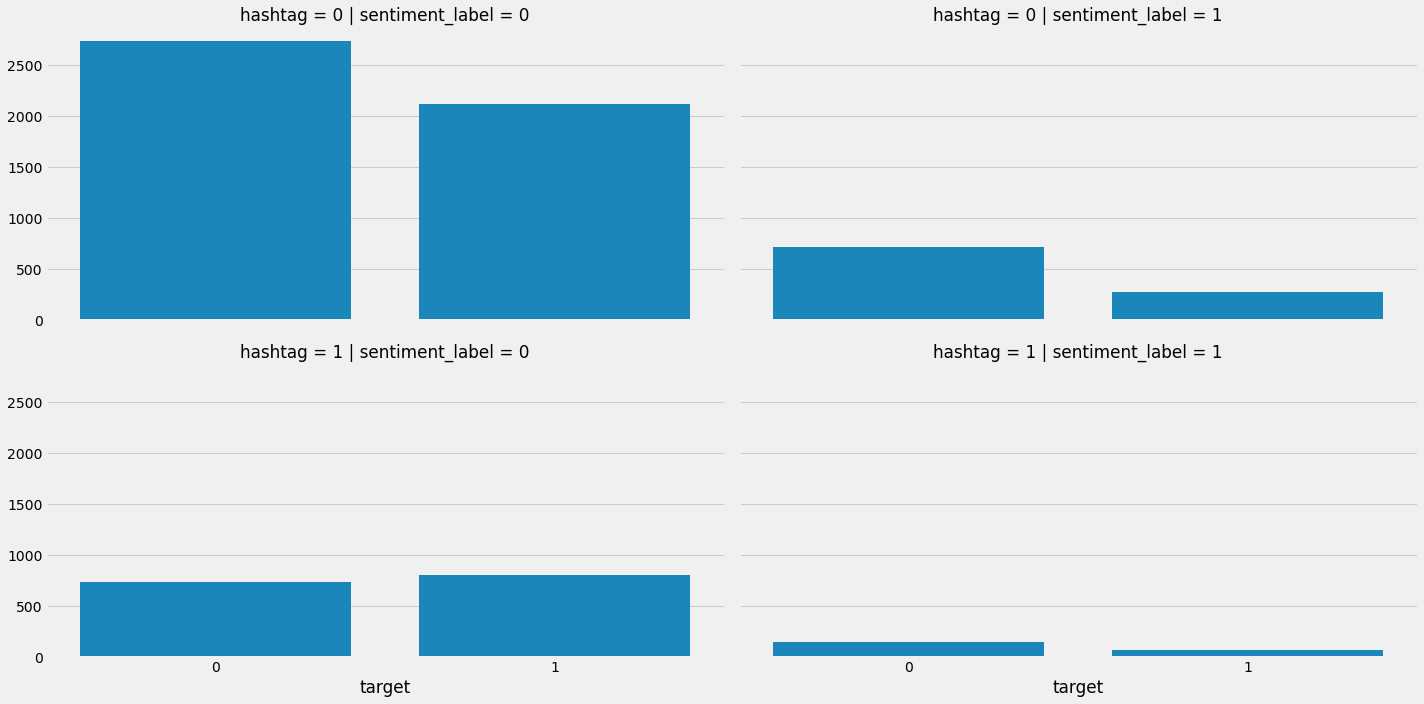

In [18]:
g = sns.FacetGrid(train_full, row='hashtag', col='sentiment_label',
                 height=5, aspect=2)
g.map(sns.countplot, 'target')
plt.tight_layout()

In [19]:
train_full['location'] = train_full['location'].apply(lambda loc: 0 if 'none' in loc else 1)
train_full.head()

,keyword,location,text,target,hashtag,sentiment_label,sentiment_conf
id,,,,,,,
1,none,0,Our Deeds are the Reason of this #earthquake M...,1,1,0,0.726392
4,none,0,Forest fire near La Ronge Sask. Canada,1,0,0,0.984948
5,none,0,All residents asked to 'shelter in place' are ...,1,0,0,0.979095
6,none,0,"13,000 people receive #wildfires evacuation or...",1,1,0,0.984415
7,none,0,Just got sent this photo from Ruby #Alaska as ...,1,1,0,0.973235


In [20]:
X = train_full.drop(['keyword', 'text', 'target'], axis=1)
y = train_full['target']

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

In [24]:
parameters = {'n_estimators': np.arange(100, 600, 100),
             'criterion': ['gini', 'entropy'],
             'warm_start': [False, True],
             'max_features': ['auto', 'sqrt', 'log2']}

In [25]:
model = RandomForestClassifier()

In [26]:
clf = GridSearchCV(model, parameters)

In [27]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': array([100, 200, 300, 400, 500]),
                         'warm_start': [False, True]})

In [28]:
clf.cv_results_

{'mean_fit_time': array([0.56573572, 0.46690917, 0.85689664, 0.73310719, 1.08886189,
        1.08529544, 1.45441923, 1.45975962, 1.8346642 , 1.84298048,
        0.36342263, 0.36249771, 0.73245516, 0.72187309, 1.10066676,
        1.09666557, 1.4850656 , 1.48487506, 1.86891327, 1.8734015 ,
        0.3704205 , 0.36874518, 0.74324722, 0.73437457, 1.12277608,
        1.09374471, 1.4862885 , 1.47404065, 1.83954043, 1.83623385,
        0.60312304, 0.59687529, 1.18589897, 1.19243302, 1.80170174,
        1.83111181, 2.41449256, 2.47688198, 3.01598392, 2.99916263,
        0.59742503, 0.59401035, 1.21193223, 1.54268103, 1.87961407,
        1.81675363, 2.41913958, 2.38476167, 2.95950103, 3.05620031,
        0.62712355, 0.60126505, 1.19442592, 1.2070416 , 1.80111604,
        1.77405434, 2.40340338, 2.37620177, 2.98825288, 2.99427004]),
 'std_fit_time': array([0.04505616, 0.03684391, 0.01944604, 0.02038708, 0.02320554,
        0.02100176, 0.02295084, 0.02491485, 0.02393929, 0.02372015,
        0.006